In [1]:
from sympy import *
import numpy as np
from itertools import combinations
import pandas as pd
import numpy as np
import sys
import networkx as nx
import torch

sys.path.append('./')

print(sys.path)

import pyximport; pyximport.install(inplace=True)
from direct_lingam.ReLVLiNGAM import *
from direct_lingam.simulate_data import *
from direct_lingam.DAG import plot_dag
from scipy import optimize
from cardano_method import CubicEquation


import matplotlib.pyplot as plt

['/home/ykivva/ykivva/research/iv_dependant/generilized_did', '/home/ykivva/anaconda3/envs/experiments/lib/python311.zip', '/home/ykivva/anaconda3/envs/experiments/lib/python3.11', '/home/ykivva/anaconda3/envs/experiments/lib/python3.11/lib-dynload', '', '/home/ykivva/anaconda3/envs/experiments/lib/python3.11/site-packages', './']


Lambda is 
 [[0 0 0]
 [1 0 0]
 [0 1 0]]


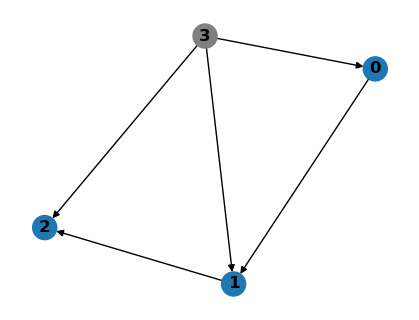

In [2]:
Lambda = get_Lambda([(1,0), (2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1], [1], [1]])
highest_l = 1
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [3]:
from direct_lingam.constraints_to_test import get_constraints_for_l_latents
class DiDLiNGAM(ReLVLiNGAM):
    def __init__(self,
                 *args,
                 **kwargs):
        """
        Initialize the DiDLiNGAM model.

        Parameters:
        *args: positional arguments
        **kwargs: keyword arguments
        """
        super().__init__(*args, **kwargs)
        self.cumulants = self._estimate_cumulants(self.X)
        self.roots_10, self.is_real10 = self.__get__roots(i=1, j=0)
        self.roots_20, self.is_real20 = self.__get__roots(i=2, j=0)



    def estimate_effect(self, method="cumulant", true_B = None):
        """
        Estimate the causal effect using the specified method.

        Parameters:
        method (str): The method to use for effect estimation. Can be "ratio" or "cumulant".

        Raises:
        ValueError: If the specified method is not supported.
        """
        if method == "ratio":
            matching_1 = [[self.roots_10[0], self.roots_20[0]], [self.roots_10[1], self.roots_20[1]]]
            matching_2 = [[self.roots_10[0], self.roots_20[1]], [self.roots_10[1], self.roots_20[0]]]
            matchings = [matching_1, matching_2]
            self.matchings = matchings
            self.causal_effect = self.__estimate__effect_ratio()
        elif method == "cumulant":
            marginal_omegas_10 = self.__marginal__cumulants(j=0, i=1)
            marginal_omegas_20 = self.__marginal__cumulants(j=0, i=2)
            match = self.__match__marginals(marginal_omegas_10, marginal_omegas_20)
            roots_1 = [self.roots_10[match[0][0]], self.roots_20[match[0][1]]]
            roots_2 = [self.roots_10[match[1][0]], self.roots_20[match[1][1]]]
            self.roots = [roots_1, roots_2]
            self.causal_effect = self.__estimate__effect_cumulant(roots_1, roots_2)
        elif method == "cumulant_with_true_matrix": #add this to the plot
            self.causal_effect = self.__estimate__effect_cumulant(true_B[1:, 0], true_B[1:, 3])
        elif method == "ratio_after_matching":
            marginal_omegas_10 = self.__marginal__cumulants(j=0, i=1)
            marginal_omegas_20 = self.__marginal__cumulants(j=0, i=2)
            match = self.__match__marginals(marginal_omegas_10, marginal_omegas_20)
            self.causal_effect = self.__estimate__effect_ratio_after_matching(match)
        else:
            raise ValueError(f"Method {method} is not supported.")

    def __get__roots(self, i=1, j=0):
        """
        Get the roots of the polynomial equations for the specified nodes.

        Parameters:
        i (int): The index of the first node.
        j (int): The index of the second node.

        Returns:
        numpy.ndarray: The roots of the polynomial equations.
        """
        equations_bij = get_constraints_for_l_latents(1)["equations_bij"]

        eq = equations_bij[0]
        # eq = sum(equations_bij)

        # for eq in equations_bij:
        specify_nodes = {
            sym: symbols(
                sym.name[:2] + "".join(sorted(sym.name[2:].replace("j", str(j)).replace("i", str(i))))
            )
            for sym in reduce(set.union, [eq.free_symbols for eq in equations_bij])
            if str(sym) != "b_ij"
        }
        symbols_to_cumulants = self._form_symbol_to_cumulant_dict(self.cumulants, [i, j], scale_partly=False)
        estimated_coeffs = [float(coeff.subs(specify_nodes).subs(symbols_to_cumulants)) for coeff in eq.all_coeffs()]
        # roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)
        # /len(equations_bij)
        roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots()
        is_real = np.all(np.isreal(roots))
        roots = roots.astype(np.float64)
        return roots, is_real

    def __marginal__cumulants(self, j=0, i=1):
        """
        Estimate the marginal cumulants for the specified nodes.

        Parameters:
        j (int): The index of the first node.
        i (int): The index of the second node.

        Returns:
        numpy.ndarray: The estimated marginal cumulants.
        """
        source, other_node = j, i
        l = self.highest_l  # The number of latent variables confounding 1 and 2
        highest_order = 4  # Order up to which to estimate cumulants
        marginal_omegas = np.full((self.highest_l + 1, self.highest_order - 1), np.nan)
        # For k < l+1, the marginal omega cannot be inferred.
        for k in range(l + 1, highest_order + 1):
            roots = self.roots_10 if i == 1 else self.roots_20
            B_tilde = [roots ** i for i in range(k)]
            symbols_to_cumulants = self._form_symbol_to_cumulant_dict(self.cumulants, [i, j], scale_partly=False)
            y = np.array(
                [
                    float(symbols_to_cumulants[symbols(f"c_{''.join(sorted((str(source),) * (k - i) + (str(other_node),) * i))}")])
                    for i in range(k)
                ]
            )
            try:
                marginal_omegas[:, k - 2] = np.linalg.lstsq(B_tilde, y, rcond=None)[0]
            except np.linalg.LinAlgError:
                raise MathError(f"Linear system for {k}th order omega for source {source} and test node {other_node} is singular.")

        return marginal_omegas

    def __match__marginals(self, marginal_omegas_10, marginal_omegas_20):
        """
        Match the marginal cumulants of the two nodes.

        Parameters:
        marginal_omegas_10 (numpy.ndarray): The marginal cumulants of node 1.
        marginal_omegas_20 (numpy.ndarray): The marginal cumulants of node 2.

        Returns:
        list: The matching indices for the marginal cumulants.
        """
        if marginal_omegas_10.shape[0] != marginal_omegas_20.shape[0]:
            raise ValueError("The number of rows of the marginal omegas must be the same.")
        if marginal_omegas_10.shape[1] != marginal_omegas_20.shape[1]:
            raise ValueError("The number of columns of the marginal omegas must be the same.")
        match_1, match_2 = [[0, 0], [1, 1]], [[0, 1], [1, 0]]
        dist_1 = np.sum(np.abs((marginal_omegas_10 - marginal_omegas_20)))
        dist_2 = np.sum(np.abs((marginal_omegas_10 - marginal_omegas_20[[1, 0]])))
        if dist_1 < dist_2:
            return match_1
        else:
            return match_2

    def __estimate__effect_cumulant(self, roots_1, roots_2):
        """
        Estimate the causal effect using the cumulant method.

        Parameters:
        match (list): The matching indices for the marginal cumulants.

        Returns:
        float: The estimated causal effect.
        """
        def ratio_formula(root, cov_matrix):
            return (cov_matrix[1, 2] - root * cov_matrix[0, 2]) / (cov_matrix[1, 1] - root * cov_matrix[0, 1])

        # Estimate the causal effect
        b_2 = ratio_formula(roots_1[0], self.cumulants.get(2))
        b_1 = ratio_formula(roots_2[0], self.cumulants.get(2))

        diff_1 = np.abs(roots_1[1] - b_1 * roots_1[0])
        diff_2 = np.abs(roots_2[1] - b_2 * roots_2[0])

        if np.argmin([diff_1, diff_2]) == 0:
            return b_1
        else:
            return b_2

    def __estimate__effect_ratio(self):
        """
        Estimate the causal effect using the ratio method.

        Returns:
        float: The estimated causal effect.
        """
        matchings = self.matchings
        ratios = []
        for matching in matchings:
            X_matching = []
            for pair in matching:
                X_pair = self.X.copy()
                X_pair[:, 1] -= self.X[:, 0] * pair[0]
                X_pair[:, 2] -= self.X[:, 0] * pair[1]
                X_matching.append(X_pair)

            var_1 = np.cov([X_matching[0][:, 1], X_matching[1][:, 1]])[0, 1]
            cov_1 = np.cov(X_matching[0][:, 1], X_matching[1][:, 2])[0, 1]
            cov_2 = np.cov(X_matching[1][:, 1], X_matching[0][:, 2])[0, 1]

            ratio = sorted([cov_1/var_1, cov_2/var_1], key = abs)
            ratios.append(ratio)

        diff_ratios = [np.abs(r[1] - r[0]) for r in ratios]
        # return np.mean(ratios[diff_ratios.index(min(diff_ratios))])
        return np.mean(ratios[np.argmin(diff_ratios)])




    def __estimate__effect_ratio_after_matching(self, match):
        """
        Estimate the causal effect using the latent factor method.

        Parameters:
        match (list): The matching indices for the marginal cumulants.

        Returns:
        float: The estimated causal effect.
        """

        roots_1 = [self.roots_10[match[0][0]], self.roots_20[match[0][1]]]
        roots_2 = [self.roots_10[match[1][0]], self.roots_20[match[1][1]]]
        roots = [roots_1, roots_2]
        X_regs = []
        for root in roots:
            X_pair = self.X.copy()
            X_pair[:, 1] -= self.X[:, 0] * root[0]
            X_pair[:, 2] -= self.X[:, 0] * root[1]
            X_regs.append(X_pair)

        var_1 = np.cov([X_regs[0][:, 1], X_regs[1][:, 1]])[0, 1]
        cov_1 = np.cov(X_regs[0][:, 1], X_regs[1][:, 2])[0, 1]
        cov_2 = np.cov(X_regs[1][:, 1], X_regs[0][:, 2])[0, 1]


        return  np.mean([cov_1/var_1, cov_2/var_1])

def get_ratio_(Z, D, deg=2):
    """
    Computes ratio between alpha_d/alpha_z

    Parameters:
        - Z (np.array): proxy variable observations
        - D (np.array): treatment observations
        - deg (int): moment of non-guassianity (equal to the (n-1) from the original paper)
    """
    var_u = np.mean(Z*D)
    sign = np.sign(var_u)

    diff_normal_D = np.mean(D**(deg)*Z) - deg*var_u*np.mean(D**(deg-1))
    diff_normal_Z = np.mean(Z**(deg)*D) - deg*var_u*np.mean(Z**(deg-1))

    alpha_sq = ((diff_normal_D) / (diff_normal_Z))
    if alpha_sq < 0:
        alpha_sq = -(abs(alpha_sq)**(1/(deg-1)))
    else:
        alpha_sq = alpha_sq**(1/(deg-1))
    alpha_sq = abs(alpha_sq)*sign

    return alpha_sq


def cross_moment(Z, D, Y, deg=2):
    """
    Cross-Moment method implementation

    Parameters:
        - Z (np.array): proxy variable observations
        - D (np.array): treatment observations
        - Y (np.array): outcome observations
        - deg (int): moment of non-guassianity (equal to the (n-1) from the original paper)
    """
    denominator = 0
    while denominator==0:
        alpha_sq = get_ratio_(Z, D, deg)
        numerator = np.mean(D*Y) - alpha_sq*np.mean(Y*Z)
        denominator = np.mean(D*D) - alpha_sq*np.mean(D*Z)
        deg += 1
    return numerator / denominator

In [ ]:
n = 10000
noise_distribution = "beta"
X, true_B = simulate_data(n,
                          noise_distribution=noise_distribution,
                          Lambda=Lambda,
                          Gamma=Gamma,
                          permute_order=False)
X_sample = np.asfortranarray(X)
X_sample = X_sample - np.mean(X_sample, axis=0)

did_model = DiDLiNGAM(X_sample, highest_l = 1)
did_model.estimate_effect("cumulant")
causal_effect_estimate_cumulant = did_model.causal_effect

In [ ]:
beta = true_B[2, 1]
print("Estimation with cumulant:", causal_effect_estimate_cumulant)
Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 
YYZ = (Y*Y*Z).mean()
YXZ = (Y*X*Z).mean()
XXZ = (X*X*Z).mean()
YXX = (Y*X*X).mean()
XXX = (X*X*X).mean()
a0 = YYZ * YXX
a1 = -XXX*YYZ - 2*YXZ*YXX
a2 = XXZ*YXX + 2*YXZ*XXX
a3 = -XXZ*XXX

YZZ = (Y*Z*Z).mean()
XZZ = (X*Z*Z).mean()
YYX = (Y*Y*X).mean()
YXX = (Y*X*X).mean()
XXX = (X*X*X).mean()
b0 = YZZ*YYX
b1 = -XZZ*YYX - 2*YXX*YZZ
b2 = YZZ*XXX + 2*YXX*XZZ
b3 = -XZZ*XXX

cov21 = (Y*X).mean()
cov20 = (Y*Z).mean()
cov11 = (X*X).mean()
cov10 = (X*Z).mean()

def f_min(x):
    global a0
    global a1
    global a2
    global a3
    global b0
    global b1
    global b2
    global b3
    global cov21
    global cov20
    global cov11
    global cov10

    k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

    return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2

x0  = causal_effect_estimate_cumulant 
sol = optimize.minimize(f_min, x0, method='BFGS')
beta_est = sol.x[0]
print("Estimate with minimize: ", beta_est)

def f_min_reg(x):
    global a0
    global a1
    global a2
    global a3
    global b0
    global b1
    global b2
    global b3
    global cov21
    global cov20
    global cov11
    global cov10
    global causal_effect_estimate_cumulant

    k = (a0 + a1*x + a2*x*x+a3*x*x*x) / (b0 + b1*x + b2*x*x+b3*x*x*x)

    return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + (x-causal_effect_estimate_cumulant)**2

x0  = causal_effect_estimate_cumulant 
sol = optimize.minimize(f_min_reg, x0, method='BFGS')
beta_est = sol.x[0]
print("Estimate with regularized minimized: ", beta_est)

def f(x):
    global a0
    global a1
    global a2
    global a3
    global b0
    global b1
    global b2
    global b3
    global cov21
    global cov20
    global cov11
    global cov10
    
    k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)
    
    return x - (cov21 - k*cov20) / (cov11-k*cov10)
# sol = optimize.root_scalar(f, bracket=[beta-max(0.5, beta*0.5), beta+max(0.5, beta*0.5)], method='brentq')
# print("Pol sol:", sol)

c0 = cov21*b0 - cov20*a0
c1 = cov21*b1 - a1*cov20 - cov11*b0 + a0*cov10
c2 = cov21*b2 - cov20*a2 - cov11*b1 + cov10*a1
c3 = cov10*a2 - cov11*b2
roots = np.roots([c3, c2, c1, c0])
print("Roots:", roots)

print("True beta:", beta)

In [ ]:
k = (a0 + a1*beta + a2*beta*beta + a3*beta*beta*beta) / (b0 + b1*beta + b2*beta*beta + b3*beta*beta*beta)
print((cov21 - k*cov20))
print((cov11-k*cov10))
print((cov21 - k*cov20) / (cov11-k*cov10))
print(beta)

In [ ]:
noise_distribution = "beta"
n_exp = 100

betas = {}
betas_cumulant = {}
betas_cumulant_true_matrix = {}
is_real_roots = {}
betas_est = {}
betas_est_true_start = {}

n_samples_list = [1000, 1500, 2000, 2500, 3000, 4000, 5000, 10000, 15000, 20000, 25000]
for n_samples in n_samples_list:
    betas[n_samples] = []
    betas_cumulant[n_samples] = []
    betas_cumulant_true_matrix[n_samples] = []
    betas_est[n_samples] = []
    betas_est_true_start[n_samples] = []
    is_real_roots[n_samples] = []
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect
        
        real_roots = did_model.is_real10 and did_model.is_real20
        
        beta = true_B[2, 1]
        betas[n_samples].append(beta)
        betas_cumulant[n_samples].append(causal_effect_estimate_cumulant)
        is_real_roots[n_samples].append(real_roots)
        
        did_model.estimate_effect("cumulant_with_true_matrix", true_B)
        causal_effect_estimate_cumulant_true_matrix = did_model.causal_effect
        betas_cumulant_true_matrix[n_samples].append(causal_effect_estimate_cumulant_true_matrix)
        
        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
    
        def f_min(x):
            global a0
            global a1
            global a2
            global a3
            global b0
            global b1
            global b2
            global b3
            global cov21
            global cov20
            global cov11
            global cov10

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2
        
        x0  = causal_effect_estimate_cumulant
        sol = optimize.minimize(f_min, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est[n_samples].append(beta_est)
        
        x0  = beta + np.random.rand()*0.1
        sol = optimize.minimize(f_min, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est_true_start[n_samples].append(beta_est)

In [ ]:
betas_est_avg = {}
betas_est_err = {}

betas_est_avg_true_start = {}
betas_est_err_true_start = {}

betas_est_avg_cumulant = {}
betas_est_err_cumulant = {}

betas_est_avg_cumulant_true_matrix = {}
betas_est_err_cumulant_true_matrix = {}

for key in betas.keys():
    mask = np.array(is_real_roots[key])
    beta_est_avg = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg[key] = beta_est_avg
    betas_est_err[key] = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_true_start = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_true_start[key] = beta_est_avg_true_start
    betas_est_err_true_start[key] = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant[key] = beta_est_avg_cumulant
    betas_est_err_cumulant[key] = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant_true_matrix = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant_true_matrix[key] = beta_est_avg_cumulant_true_matrix
    betas_est_err_cumulant_true_matrix[key] = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()

In [ ]:
x = n_samples_list
y = np.array(list(betas_est_avg.values()))
err = np.array(list(betas_est_err.values()))

y_true_start = np.array(list(betas_est_avg_true_start.values()))
err_true_start = np.array(list(betas_est_err_true_start.values()))

y_cumulant = np.array(list(betas_est_avg_cumulant.values()))
err_cumulant = np.array(list(betas_est_err_cumulant.values()))

y_cumulant_true_matrix = np.array(list(betas_est_avg_cumulant_true_matrix.values()))
err_cumulant_true_matrix = np.array(list(betas_est_err_cumulant_true_matrix.values()))

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Distribution: Exponential")
plt.xlabel("Sample size")
plt.ylabel("Estimate beta")

plt.plot(x, y, label="Estimation: Minimization", color="blue")
plt.fill_between(x, y-err, y+err, alpha=0.1)

plt.plot(x, y_true_start, label="Estimation: Minimization (True Init Point)", color="violet")
plt.fill_between(x, y_true_start-err_true_start, y_true_start+err_true_start, alpha=0.1)

plt.plot(x, y_cumulant, label="Estimation: Cumulant", color="red")
plt.fill_between(x, y_cumulant-err_cumulant, y_cumulant+err_cumulant, alpha=0.1)

plt.plot(x, y_cumulant_true_matrix, label="Estimation: Cumulant from true matrix", color="black")
plt.fill_between(x, y_cumulant_true_matrix-err_cumulant_true_matrix, y_cumulant_true_matrix+err_cumulant_true_matrix, alpha=0.1)

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1.5)
plt.show()

In [ ]:
noise_distribution = "beta"
n_exp = 10
alpha = 1
betas = {}

betas_cumulant = {}
betas_cumulant_true_matrix = {}
is_real_roots = {}
betas_est = {}
betas_est_true_start = {}
n_samples_list = [1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000]
for n_samples in n_samples_list:
    betas[n_samples] = []
    betas_cumulant[n_samples] = []
    betas_cumulant_true_matrix[n_samples] = []
    betas_est[n_samples] = []
    betas_est_true_start[n_samples] = []
    is_real_roots[n_samples] = []
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect
        
        real_roots = did_model.is_real10 and did_model.is_real20
        
        beta = true_B[2, 1]
        betas[n_samples].append(beta)
        betas_cumulant[n_samples].append(causal_effect_estimate_cumulant)
        is_real_roots[n_samples].append(real_roots)
        
        did_model.estimate_effect("cumulant_with_true_matrix", true_B)
        causal_effect_estimate_cumulant_true_matrix = did_model.causal_effect
        betas_cumulant_true_matrix[n_samples].append(causal_effect_estimate_cumulant_true_matrix)
        
        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
    
        def f_min_reg(x):
            global alpha
            global a0
            global a1
            global a2
            global a3
            global b0
            global b1
            global b2
            global b3
            global cov21
            global cov20
            global cov11
            global cov10
            global causal_effect_estimate_cumulant

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - causal_effect_estimate_cumulant)**2
        
        x0  = causal_effect_estimate_cumulant
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est[n_samples].append(beta_est)
        
        x0  = beta + np.random.rand()*0.1
        sol = optimize.minimize(f_min, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est_true_start[n_samples].append(beta_est)

In [ ]:
betas_est_avg = {}
betas_est_err = {}

betas_est_avg_true_start = {}
betas_est_err_true_start = {}

betas_est_avg_cumulant = {}
betas_est_err_cumulant = {}

betas_est_avg_cumulant_true_matrix = {}
betas_est_err_cumulant_true_matrix = {}

for key in betas.keys():
    mask = np.array(is_real_roots[key])
    beta_est_avg = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg[key] = beta_est_avg
    betas_est_err[key] = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_true_start = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_true_start[key] = beta_est_avg_true_start
    betas_est_err_true_start[key] = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant[key] = beta_est_avg_cumulant
    betas_est_err_cumulant[key] = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant_true_matrix = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant_true_matrix[key] = beta_est_avg_cumulant_true_matrix
    betas_est_err_cumulant_true_matrix[key] = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()

In [ ]:
x = n_samples_list
y = np.array(list(betas_est_avg.values()))
err = np.array(list(betas_est_err.values()))

y_true_start = np.array(list(betas_est_avg_true_start.values()))
err_true_start = np.array(list(betas_est_err_true_start.values()))

y_cumulant = np.array(list(betas_est_avg_cumulant.values()))
err_cumulant = np.array(list(betas_est_err_cumulant.values()))

y_cumulant_true_matrix = np.array(list(betas_est_avg_cumulant_true_matrix.values()))
err_cumulant_true_matrix = np.array(list(betas_est_err_cumulant_true_matrix.values()))

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Distribution: Beta")
plt.xlabel("Iterations")
plt.ylabel("Estimate beta")

plt.plot(x, y, label="Estimation: Minimization", color="blue")
plt.fill_between(x, y-err, y+err, alpha=0.1)

plt.plot(x, y_true_start, label="Estimation: Minimization (True Init Point)", color="violet")
plt.fill_between(x, y_true_start-err_true_start, y_true_start+err_true_start, alpha=0.1)

plt.plot(x, y_cumulant, label="Estimation: Cumulant", color="red")
plt.fill_between(x, y_cumulant-err_cumulant, y_cumulant+err_cumulant, alpha=0.1)

plt.plot(x, y_cumulant_true_matrix, label="Estimation: Cumulant from true matrix", color="black")
plt.fill_between(x, y_cumulant_true_matrix-err_cumulant_true_matrix, y_cumulant_true_matrix+err_cumulant_true_matrix, alpha=0.1)

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1.5)
plt.show()

In [ ]:
# Box plot
# Check median

## Additional experiments

In [ ]:
from src_LiNGAM.python.methods import graphical_rica, init_w_guess_

In [ ]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [ ]:
latent = 1 
observed = 3
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
w_id = 4

epochs = 200

n_exp = 50
betas = {}
betas_cumulant = {}
betas_cumulant_true_matrix = {}
is_real_roots = {}
betas_est = {}
betas_est_true_start = {}
betas_grica = {}

n_samples_list = [1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000, 20000, 30000, 50000, 70000, 100000]
for n_samples in n_samples_list:
    betas[n_samples] = []
    betas_cumulant[n_samples] = []
    betas_cumulant_true_matrix[n_samples] = []
    betas_est[n_samples] = []
    betas_est_true_start[n_samples] = []
    is_real_roots[n_samples] = []
    betas_grica[n_samples] = []
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)
        
        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect
        
        real_roots = did_model.is_real10 and did_model.is_real20
        
        beta = true_B[2, 1]
        betas[n_samples].append(beta)
        betas_cumulant[n_samples].append(causal_effect_estimate_cumulant)
        is_real_roots[n_samples].append(real_roots)
        
        did_model.estimate_effect("cumulant_with_true_matrix", true_B)
        causal_effect_estimate_cumulant_true_matrix = did_model.causal_effect
        betas_cumulant_true_matrix[n_samples].append(causal_effect_estimate_cumulant_true_matrix)
        
        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
    
        def f_min_reg(x):
            global alpha
            global a0
            global a1
            global a2
            global a3
            global b0
            global b1
            global b2
            global b3
            global cov21
            global cov20
            global cov11
            global cov10
            global causal_effect_estimate_cumulant

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - causal_effect_estimate_cumulant)**2
        
        x0  = causal_effect_estimate_cumulant
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est[n_samples].append(beta_est)
        
        x0  = beta + np.random.rand()*0.1
        sol = optimize.minimize(f_min, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est_true_start[n_samples].append(beta_est)
        
        data = torch.tensor(X_sample, dtype=torch.float64)
        d_cov = (data.t()).cov()
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = torch.empty(len(list(g.edges)), dtype=torch.float64).fill_(true_B[2, 1])
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        betas_grica[n_samples].append(weight_pred[w_id].detach().item())

In [ ]:
betas_est_avg = {}
betas_est_err = {}

betas_est_avg_true_start = {}
betas_est_err_true_start = {}

betas_est_avg_cumulant = {}
betas_est_err_cumulant = {}

betas_est_avg_cumulant_true_matrix = {}
betas_est_err_cumulant_true_matrix = {}

betas_est_avg_grica = {}
betas_est_err_grica = {}

for key in betas.keys():
    mask = np.array(is_real_roots[key])
    
    beta_est_avg = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg[key] = beta_est_avg
    betas_est_err[key] = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_true_start = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_true_start[key] = beta_est_avg_true_start
    betas_est_err_true_start[key] = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant[key] = beta_est_avg_cumulant
    betas_est_err_cumulant[key] = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant_true_matrix = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant_true_matrix[key] = beta_est_avg_cumulant_true_matrix
    betas_est_err_cumulant_true_matrix[key] = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_grica = np.abs((np.array(betas_grica[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_grica[key] = beta_est_avg_grica
    betas_est_err_grica[key] = np.abs((np.array(betas_grica[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()

In [ ]:
# Add regularization for true starting point
# Starting point: GRICA

In [ ]:
x = n_samples_list
y = np.array(list(betas_est_avg.values()))
err = np.array(list(betas_est_err.values()))

y_true_start = np.array(list(betas_est_avg_true_start.values()))
err_true_start = np.array(list(betas_est_err_true_start.values()))

y_cumulant = np.array(list(betas_est_avg_cumulant.values()))
err_cumulant = np.array(list(betas_est_err_cumulant.values()))

y_cumulant_true_matrix = np.array(list(betas_est_avg_cumulant_true_matrix.values()))
err_cumulant_true_matrix = np.array(list(betas_est_err_cumulant_true_matrix.values()))

y_grica = np.array(list(betas_est_avg_grica.values()))
err_grica = np.array(list(betas_est_err_grica.values()))

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Number of samples vs Error")
plt.xlabel("Number of samples")
plt.ylabel("Error")

plt.plot(x, y, label="Estimation: Min with Regularization", color="blue")
plt.fill_between(x, y-err, y+err, alpha=0.1)

plt.plot(x, y_true_start, label="Estimation: Minimization (True Init Point)", color="violet")
plt.fill_between(x, y_true_start-err_true_start, y_true_start+err_true_start, alpha=0.1)

plt.plot(x, y_cumulant, label="Estimation Cumulant", color="red")
plt.fill_between(x, y_cumulant-err_cumulant, y_cumulant+err_cumulant, alpha=0.1)

plt.plot(x, y_cumulant_true_matrix, label="Estimation: Cumulant from true matrix", color="black")
plt.fill_between(x, y_cumulant_true_matrix-err_cumulant_true_matrix, y_cumulant_true_matrix+err_cumulant_true_matrix, alpha=0.1)

plt.plot(x, y_grica, label="Estimation GRICA", color="green")
plt.fill_between(x, y_grica-err_grica, y_grica+err_grica, alpha=0.1)

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1)
plt.show()

# Comparison with GRica 

In [4]:
from src_LiNGAM.python.methods import graphical_rica, init_w_guess_

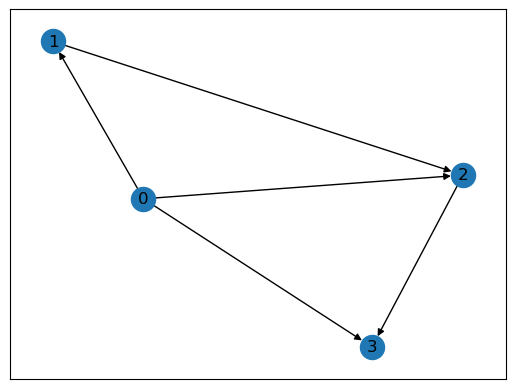

In [5]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [8]:
latent = 1 
observed = 3
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
w_id = 4

epochs = 200

n_exp = 50
betas = {}
betas_cumulant = {}
betas_cumulant_true_matrix = {}
is_real_roots = {}
betas_est = {}
betas_est_true_start = {}
betas_grica = {}

alpha = 1
noise_distribution = 'beta'
n_samples_list = [1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000, 20000, 30000, 50000]
for n_samples in n_samples_list:
    betas[n_samples] = []
    betas_cumulant[n_samples] = []
    betas_cumulant_true_matrix[n_samples] = []
    betas_est[n_samples] = []
    betas_est_true_start[n_samples] = []
    is_real_roots[n_samples] = []
    betas_grica[n_samples] = []
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)
        
        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect
        
        real_roots = did_model.is_real10 and did_model.is_real20
        
        beta = true_B[2, 1]
        betas[n_samples].append(beta)
        betas_cumulant[n_samples].append(causal_effect_estimate_cumulant)
        is_real_roots[n_samples].append(real_roots)
        
        did_model.estimate_effect("cumulant_with_true_matrix", true_B)
        causal_effect_estimate_cumulant_true_matrix = did_model.causal_effect
        betas_cumulant_true_matrix[n_samples].append(causal_effect_estimate_cumulant_true_matrix)
        
        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
    
        def f_min_reg(x):
            global alpha
            global a0
            global a1
            global a2
            global a3
            global b0
            global b1
            global b2
            global b3
            global cov21
            global cov20
            global cov11
            global cov10
            global causal_effect_estimate_cumulant

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - causal_effect_estimate_cumulant)**2
        
        x0  = causal_effect_estimate_cumulant
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est[n_samples].append(beta_est)
        
        x0  = beta + np.random.rand()*0.1
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est_true_start[n_samples].append(beta_est)
        
        data = torch.tensor(X_sample, dtype=torch.float64)
        d_cov = (data.t()).cov()
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = torch.empty(len(list(g.edges)), dtype=torch.float64).fill_(true_B[2, 1])
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        betas_grica[n_samples].append(weight_pred[w_id].detach().item())

NameError: name 'f_min' is not defined

In [ ]:
betas_est_avg = {}
betas_est_err = {}

betas_est_avg_true_start = {}
betas_est_err_true_start = {}

betas_est_avg_cumulant = {}
betas_est_err_cumulant = {}

betas_est_avg_cumulant_true_matrix = {}
betas_est_err_cumulant_true_matrix = {}

betas_est_avg_grica = {}
betas_est_err_grica = {}

for key in betas.keys():
    mask = np.array(is_real_roots[key])
    
    beta_est_avg = np.abs((np.array(betas_est[key]) - np.array(betas[key])) / np.array(betas[key])).mean()
    betas_est_avg[key] = beta_est_avg
    betas_est_err[key] = np.abs((np.array(betas_est[key]) - np.array(betas[key])) / np.array(betas[key])).std()
    
    beta_est_avg_true_start = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_true_start[key] = beta_est_avg_true_start
    betas_est_err_true_start[key] = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant = np.abs((np.array(betas_cumulant[key]) - np.array(betas[key])) / np.array(betas[key])).mean()
    betas_est_avg_cumulant[key] = beta_est_avg_cumulant
    betas_est_err_cumulant[key] = np.abs((np.array(betas_cumulant[key]) - np.array(betas[key])) / np.array(betas[key])).std()
    
    beta_est_avg_cumulant_true_matrix = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant_true_matrix[key] = beta_est_avg_cumulant_true_matrix
    betas_est_err_cumulant_true_matrix[key] = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_grica = np.abs((np.array(betas_grica[key]) - np.array(betas[key])) / np.array(betas[key])).mean()
    betas_est_avg_grica[key] = beta_est_avg_grica
    betas_est_err_grica[key] = np.abs((np.array(betas_grica[key]) - np.array(betas[key])) / np.array(betas[key])).std()

In [ ]:
# Add experiments where initial point is close to beta (beta+noise (var small)), plot with respect to var value

In [ ]:
x = n_samples_list
y = np.array(list(betas_est_avg.values()))
err = np.array(list(betas_est_err.values()))

y_true_start = np.array(list(betas_est_avg_true_start.values()))
err_true_start = np.array(list(betas_est_err_true_start.values()))

y_cumulant = np.array(list(betas_est_avg_cumulant.values()))
err_cumulant = np.array(list(betas_est_err_cumulant.values()))

y_cumulant_true_matrix = np.array(list(betas_est_avg_cumulant_true_matrix.values()))
err_cumulant_true_matrix = np.array(list(betas_est_err_cumulant_true_matrix.values()))

y_grica = np.array(list(betas_est_avg_grica.values()))
err_grica = np.array(list(betas_est_err_grica.values()))

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Number of samples vs Error")
plt.xlabel("Number of samples")
plt.ylabel("Error")

plt.plot(x, y, label="Estimation: Min with Regularization", color="blue")
plt.fill_between(x, y-err, y+err, alpha=0.1)

plt.plot(x, y_true_start, label="Estimation: Minimization (True Init Point)", color="violet")
plt.fill_between(x, y_true_start-err_true_start, y_true_start+err_true_start, alpha=0.1)

plt.plot(x, y_cumulant, label="Estimation Cumulant", color="red")
plt.fill_between(x, y_cumulant-err_cumulant, y_cumulant+err_cumulant, alpha=0.1)

plt.plot(x, y_grica, label="Estimation GRICA", color="green")
plt.fill_between(x, y_grica-err_grica, y_grica+err_grica, alpha=0.1)

plt.plot(x, y_cumulant_true_matrix, label="Estimation: Cumulant from true matrix", color="black")
plt.fill_between(x, y_cumulant_true_matrix-err_cumulant_true_matrix, y_cumulant_true_matrix+err_cumulant_true_matrix, alpha=0.1)

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1)
plt.show()

# Distribution: Exponential

In [ ]:
from src_LiNGAM.python.methods import graphical_rica, init_w_guess_

In [ ]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [ ]:
latent = 1 
observed = 3
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
w_id = 4

epochs = 200

n_exp = 50
betas = {}
betas_cumulant = {}
betas_cumulant_true_matrix = {}
is_real_roots = {}
betas_est = {}
betas_est_true_start = {}
betas_grica = {}

alpha = 1
noise_distribution = "exponential"
n_samples_list = [1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000, 20000, 30000, 50000, 70000, 100000]
for n_samples in n_samples_list:
    betas[n_samples] = []
    betas_cumulant[n_samples] = []
    betas_cumulant_true_matrix[n_samples] = []
    betas_est[n_samples] = []
    betas_est_true_start[n_samples] = []
    is_real_roots[n_samples] = []
    betas_grica[n_samples] = []
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)
        
        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect
        
        real_roots = did_model.is_real10 and did_model.is_real20
        
        beta = true_B[2, 1]
        betas[n_samples].append(beta)
        betas_cumulant[n_samples].append(causal_effect_estimate_cumulant)
        is_real_roots[n_samples].append(real_roots)
        
        did_model.estimate_effect("cumulant_with_true_matrix", true_B)
        causal_effect_estimate_cumulant_true_matrix = did_model.causal_effect
        betas_cumulant_true_matrix[n_samples].append(causal_effect_estimate_cumulant_true_matrix)
        
        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
    
        def f_min_reg(x):
            global alpha
            global a0
            global a1
            global a2
            global a3
            global b0
            global b1
            global b2
            global b3
            global cov21
            global cov20
            global cov11
            global cov10
            global causal_effect_estimate_cumulant

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - causal_effect_estimate_cumulant)**2
        
        x0  = causal_effect_estimate_cumulant
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est[n_samples].append(beta_est)
        
        x0  = beta + np.random.rand()*0.1
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est_true_start[n_samples].append(beta_est)
        
        data = torch.tensor(X_sample, dtype=torch.float64)
        d_cov = (data.t()).cov()
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = torch.empty(len(list(g.edges)), dtype=torch.float64).fill_(true_B[2, 1])
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        betas_grica[n_samples].append(weight_pred[w_id].detach().item())

In [ ]:
betas_est_avg = {}
betas_est_err = {}

betas_est_avg_true_start = {}
betas_est_err_true_start = {}

betas_est_avg_cumulant = {}
betas_est_err_cumulant = {}

betas_est_avg_cumulant_true_matrix = {}
betas_est_err_cumulant_true_matrix = {}

betas_est_avg_grica = {}
betas_est_err_grica = {}

for key in betas.keys():
    mask = np.array(is_real_roots[key])
    
    beta_est_avg = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg[key] = beta_est_avg
    betas_est_err[key] = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_true_start = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_true_start[key] = beta_est_avg_true_start
    betas_est_err_true_start[key] = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant[key] = beta_est_avg_cumulant
    betas_est_err_cumulant[key] = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant_true_matrix = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant_true_matrix[key] = beta_est_avg_cumulant_true_matrix
    betas_est_err_cumulant_true_matrix[key] = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_grica = np.abs((np.array(betas_grica[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_grica[key] = beta_est_avg_grica
    betas_est_err_grica[key] = np.abs((np.array(betas_grica[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()

In [ ]:
x = n_samples_list
y = np.array(list(betas_est_avg.values()))
err = np.array(list(betas_est_err.values()))

y_true_start = np.array(list(betas_est_avg_true_start.values()))
err_true_start = np.array(list(betas_est_err_true_start.values()))

y_cumulant = np.array(list(betas_est_avg_cumulant.values()))
err_cumulant = np.array(list(betas_est_err_cumulant.values()))

y_cumulant_true_matrix = np.array(list(betas_est_avg_cumulant_true_matrix.values()))
err_cumulant_true_matrix = np.array(list(betas_est_err_cumulant_true_matrix.values()))

y_grica = np.array(list(betas_est_avg_grica.values()))
err_grica = np.array(list(betas_est_err_grica.values()))

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Number of samples vs Error")
plt.xlabel("Number of samples")
plt.ylabel("Error")

plt.plot(x, y, label="Estimation: Min with Regularization", color="blue")
plt.fill_between(x, y-err, y+err, alpha=0.1)

plt.plot(x, y_true_start, label="Estimation: Minimization (True Init Point)", color="violet")
plt.fill_between(x, y_true_start-err_true_start, y_true_start+err_true_start, alpha=0.1)

plt.plot(x, y_cumulant, label="Estimation Cumulant", color="red")
plt.fill_between(x, y_cumulant-err_cumulant, y_cumulant+err_cumulant, alpha=0.1)

plt.plot(x, y_cumulant_true_matrix, label="Estimation: Cumulant from true matrix", color="black")
plt.fill_between(x, y_cumulant_true_matrix-err_cumulant_true_matrix, y_cumulant_true_matrix+err_cumulant_true_matrix, alpha=0.1)

plt.plot(x, y_grica, label="Estimation GRICA", color="green")
plt.fill_between(x, y_grica-err_grica, y_grica+err_grica, alpha=0.1)

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1)
plt.show()

# Distribution: Uniform

In [ ]:
from src_LiNGAM.python.methods import graphical_rica, init_w_guess_

In [ ]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [ ]:
latent = 1 
observed = 3
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
w_id = 4

epochs = 200

n_exp = 50
betas = {}
betas_cumulant = {}
betas_cumulant_true_matrix = {}
is_real_roots = {}
betas_est = {}
betas_est_true_start = {}
betas_grica = {}

alpha = 1
noise_distribution = "uniform"
n_samples_list = [1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000, 20000, 30000, 50000, 70000, 100000]
for n_samples in n_samples_list:
    betas[n_samples] = []
    betas_cumulant[n_samples] = []
    betas_cumulant_true_matrix[n_samples] = []
    betas_est[n_samples] = []
    betas_est_true_start[n_samples] = []
    is_real_roots[n_samples] = []
    betas_grica[n_samples] = []
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)
        
        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect
        
        real_roots = did_model.is_real10 and did_model.is_real20
        
        beta = true_B[2, 1]
        betas[n_samples].append(beta)
        betas_cumulant[n_samples].append(causal_effect_estimate_cumulant)
        is_real_roots[n_samples].append(real_roots)
        
        did_model.estimate_effect("cumulant_with_true_matrix", true_B)
        causal_effect_estimate_cumulant_true_matrix = did_model.causal_effect
        betas_cumulant_true_matrix[n_samples].append(causal_effect_estimate_cumulant_true_matrix)
        
        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
    
        def f_min_reg(x):
            global alpha
            global a0
            global a1
            global a2
            global a3
            global b0
            global b1
            global b2
            global b3
            global cov21
            global cov20
            global cov11
            global cov10
            global causal_effect_estimate_cumulant

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - causal_effect_estimate_cumulant)**2
        
        x0  = causal_effect_estimate_cumulant
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est[n_samples].append(beta_est)
        
        x0  = beta + np.random.rand()*0.1
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est_true_start[n_samples].append(beta_est)
        
        data = torch.tensor(X_sample, dtype=torch.float64)
        d_cov = (data.t()).cov()
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = torch.empty(len(list(g.edges)), dtype=torch.float64).fill_(true_B[2, 1])
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        betas_grica[n_samples].append(weight_pred[w_id].detach().item())

In [ ]:
betas_est_avg = {}
betas_est_err = {}

betas_est_avg_true_start = {}
betas_est_err_true_start = {}

betas_est_avg_cumulant = {}
betas_est_err_cumulant = {}

betas_est_avg_cumulant_true_matrix = {}
betas_est_err_cumulant_true_matrix = {}

betas_est_avg_grica = {}
betas_est_err_grica = {}

for key in betas.keys():
    mask = np.array(is_real_roots[key])
    
    beta_est_avg = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg[key] = beta_est_avg
    betas_est_err[key] = np.abs((np.array(betas_est[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_true_start = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_true_start[key] = beta_est_avg_true_start
    betas_est_err_true_start[key] = np.abs((np.array(betas_est_true_start[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant[key] = beta_est_avg_cumulant
    betas_est_err_cumulant[key] = np.abs((np.array(betas_cumulant[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_cumulant_true_matrix = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_cumulant_true_matrix[key] = beta_est_avg_cumulant_true_matrix
    betas_est_err_cumulant_true_matrix[key] = np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()
    
    beta_est_avg_grica = np.abs((np.array(betas_grica[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).mean()
    betas_est_avg_grica[key] = beta_est_avg_grica
    betas_est_err_grica[key] = np.abs((np.array(betas_grica[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]).std()

In [ ]:
x = n_samples_list
y = np.array(list(betas_est_avg.values()))
err = np.array(list(betas_est_err.values()))

y_true_start = np.array(list(betas_est_avg_true_start.values()))
err_true_start = np.array(list(betas_est_err_true_start.values()))

y_cumulant = np.array(list(betas_est_avg_cumulant.values()))
err_cumulant = np.array(list(betas_est_err_cumulant.values()))

y_cumulant_true_matrix = np.array(list(betas_est_avg_cumulant_true_matrix.values()))
err_cumulant_true_matrix = np.array(list(betas_est_err_cumulant_true_matrix.values()))

y_grica = np.array(list(betas_est_avg_grica.values()))
err_grica = np.array(list(betas_est_err_grica.values()))

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Number of samples vs Error")
plt.xlabel("Number of samples")
plt.ylabel("Error")

plt.plot(x, y, label="Estimation: Min with Regularization", color="blue")
plt.fill_between(x, y-err, y+err, alpha=0.1)

plt.plot(x, y_true_start, label="Estimation: Minimization (True Init Point)", color="violet")
plt.fill_between(x, y_true_start-err_true_start, y_true_start+err_true_start, alpha=0.1)

plt.plot(x, y_cumulant, label="Estimation Cumulant", color="red")
plt.fill_between(x, y_cumulant-err_cumulant, y_cumulant+err_cumulant, alpha=0.1)

plt.plot(x, y_cumulant_true_matrix, label="Estimation: Cumulant from true matrix", color="black")
plt.fill_between(x, y_cumulant_true_matrix-err_cumulant_true_matrix, y_cumulant_true_matrix+err_cumulant_true_matrix, alpha=0.1)

plt.plot(x, y_grica, label="Estimation GRICA", color="green")
plt.fill_between(x, y_grica-err_grica, y_grica+err_grica, alpha=0.1)

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1)
plt.show()

# Median

In [15]:
from src_LiNGAM.python.methods import graphical_rica, init_w_guess_

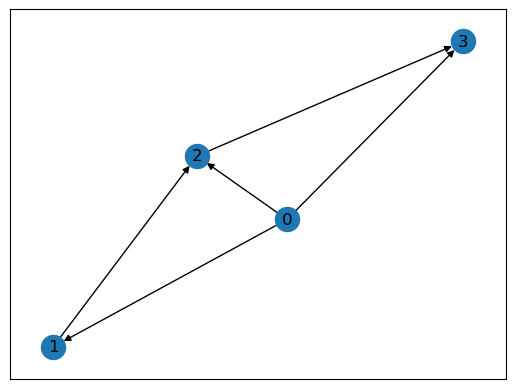

In [16]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [23]:
latent = 1 
observed = 3
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
w_id = 4

epochs = 200

n_exp = 100
betas = {}
betas_cumulant = {}
betas_cumulant_true_matrix = {}
is_real_roots = {}
betas_est = {}
betas_est_true_start = {}
betas_grica = {}
betas_cross_moment = {}
betas_est_grica_start = {}

alpha = 1
noise_distribution = "beta"
n_samples_list = [1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000, 20000, 30000, 50000]
for n_samples in n_samples_list:
    # if n_samples < 10000:
    #     n_exp = 1000
    # else:
    #     n_exp = 200
    betas[n_samples] = []
    betas_cumulant[n_samples] = []
    betas_cumulant_true_matrix[n_samples] = []
    betas_est[n_samples] = []
    betas_est_grica_start[n_samples] = []
    is_real_roots[n_samples] = []
    betas_grica[n_samples] = []
    betas_cross_moment[n_samples] = []
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)
        
        # Cumulant method
        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect
        
        # This two lines can be deleted, they work for the modified version of DiDLiNGAM class
        real_roots = did_model.is_real10 and did_model.is_real20
        is_real_roots[n_samples].append(real_roots)
        
        beta = true_B[2, 1]
        betas[n_samples].append(beta)
        betas_cumulant[n_samples].append(causal_effect_estimate_cumulant)
        
        # Estimation of beta from true matrix
        did_model.estimate_effect("cumulant_with_true_matrix", true_B)
        causal_effect_estimate_cumulant_true_matrix = did_model.causal_effect
        betas_cumulant_true_matrix[n_samples].append(causal_effect_estimate_cumulant_true_matrix)
        
        # Cumulant method with regularized part 
        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
    
        def f_min_reg(x):
            global alpha
            global a0
            global a1
            global a2
            global a3
            global b0
            global b1
            global b2
            global b3
            global cov21
            global cov20
            global cov11
            global cov10
            global causal_effect_estimate_cumulant

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - causal_effect_estimate_cumulant)**2
        
        x0  = causal_effect_estimate_cumulant
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est[n_samples].append(beta_est)
        
        # Grica method
        data = torch.tensor(X_sample, dtype=torch.float64)
        d_cov = (data.t()).cov()
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = torch.empty(len(list(g.edges)), dtype=torch.float64).fill_(true_B[2, 1])
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        beta_grica = weight_pred[w_id].detach().item()
        betas_grica[n_samples].append(beta_grica)
        
        # Estimation with function minimization where starting point GRICA output
        def f_min_reg(x):
            global alpha
            global a0
            global a1
            global a2
            global a3
            global b0
            global b1
            global b2
            global b3
            global cov21
            global cov20
            global cov11
            global cov10
            global beta_grica

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - beta_grica)**2
        x0  = beta_grica
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est_grica_start[n_samples].append(beta_est)
        
        # Cross-Moment method
        betas_cross_moment[n_samples].append(cross_moment(Z, X, Y))

/tmp/ipykernel_1707/3664645991.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  roots = roots.astype(np.float64)
/tmp/ipykernel_1707/3664645991.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  roots = roots.astype(np.float64)


In [20]:
betas_est_avg = {}
betas_est_err_25 = {}
betas_est_err_75 = {}

betas_est_avg_cumulant = {}
betas_est_err_cumulant_25 = {}
betas_est_err_cumulant_75 = {}

betas_est_avg_grica_start = {}
betas_est_err_grica_start_25 = {}
betas_est_err_grica_start_75 = {}

betas_est_avg_cross_moment = {}
betas_est_err_cross_moment_25 = {}
betas_est_err_cross_moment_75 = {}

betas_est_avg_cumulant_true_matrix = {}
betas_est_err_cumulant_true_matrix_25 = {}
betas_est_err_cumulant_true_matrix_75 = {}

betas_est_avg_grica = {}
betas_est_err_grica_25 = {}
betas_est_err_grica_75 = {}

for key in betas.keys():    
    beta_est_avg = np.median(np.abs((np.array(betas_est[key]) - np.array(betas[key])) / np.array(betas[key])))
    betas_est_avg[key] = beta_est_avg
    betas_est_err_25[key] = np.percentile(np.abs((np.array(betas_est[key]) - np.array(betas[key])) / np.array(betas[key])), 25)
    betas_est_err_75[key] = np.percentile(np.abs((np.array(betas_est[key]) - np.array(betas[key])) / np.array(betas[key])), 75)
    
    beta_est_avg_cross_moment = np.median(np.abs((np.array(betas_cross_moment[key]) - np.array(betas[key])) / np.array(betas[key])))
    betas_est_avg_cross_moment[key] = beta_est_avg_cross_moment
    betas_est_err_cross_moment_25[key] = np.percentile(np.abs((np.array(betas_cross_moment[key]) - np.array(betas[key])) / np.array(betas[key])), 25)
    betas_est_err_cross_moment_75[key] = np.percentile(np.abs((np.array(betas_cross_moment[key]) - np.array(betas[key])) / np.array(betas[key])), 75)
    
    beta_est_avg_grica_start = np.median(np.abs((np.array(betas_est_grica_start[key]) - np.array(betas[key])) / np.array(betas[key])))
    betas_est_avg_grica_start[key] = beta_est_avg_grica_start
    betas_est_err_grica_start_25[key] = np.percentile(np.abs((np.array(betas_est_grica_start[key]) - np.array(betas[key])) / np.array(betas[key])), 25)
    betas_est_err_grica_start_75[key] = np.percentile(np.abs((np.array(betas_est_grica_start[key]) - np.array(betas[key])) / np.array(betas[key])), 75)
    
    beta_est_avg_cumulant = np.median(np.abs((np.array(betas_cumulant[key]) - np.array(betas[key])) / np.array(betas[key])))
    betas_est_avg_cumulant[key] = beta_est_avg_cumulant
    betas_est_err_cumulant_25[key] = np.percentile(np.abs((np.array(betas_cumulant[key]) - np.array(betas[key])) / np.array(betas[key])), 25)
    betas_est_err_cumulant_75[key] = np.percentile(np.abs((np.array(betas_cumulant[key]) - np.array(betas[key])) / np.array(betas[key])), 75)
    
    beta_est_avg_cumulant_true_matrix = np.median(np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]))
    betas_est_avg_cumulant_true_matrix[key] = beta_est_avg_cumulant_true_matrix
    betas_est_err_cumulant_true_matrix_25[key] = np.percentile(np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]), 25)
    betas_est_err_cumulant_true_matrix_75[key] = np.percentile(np.abs((np.array(betas_cumulant_true_matrix[key])[mask] - np.array(betas[key])[mask]) / np.array(betas[key])[mask]), 75)
    
    beta_est_avg_grica = np.median(np.abs((np.array(betas_grica[key]) - np.array(betas[key])) / np.array(betas[key])))
    betas_est_avg_grica[key] = beta_est_avg_grica
    betas_est_err_grica_25[key] = np.percentile(np.abs((np.array(betas_grica[key]) - np.array(betas[key])) / np.array(betas[key])), 25)
    betas_est_err_grica_75[key] = np.percentile(np.abs((np.array(betas_grica[key]) - np.array(betas[key])) / np.array(betas[key])), 75)

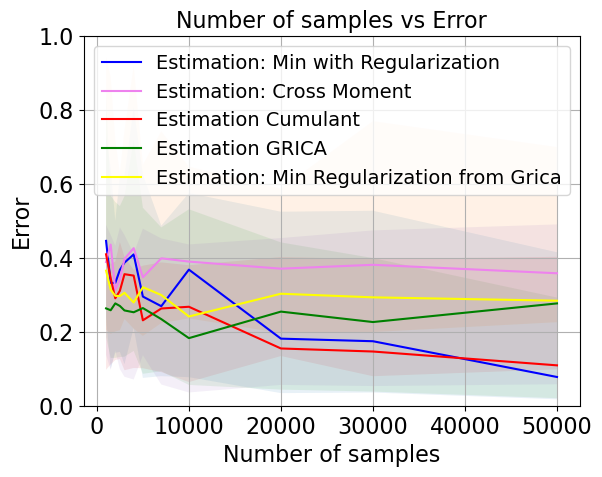

In [22]:
x = n_samples_list
y = np.array(list(betas_est_avg.values()))
err_25 = np.array(list(betas_est_err_25.values()))
err_75 = np.array(list(betas_est_err_75.values()))

y_cross_moment = np.array(list(betas_est_avg_cross_moment.values()))
err_cross_moment_25 = np.array(list(betas_est_err_cross_moment_25.values()))
err_cross_moment_75 = np.array(list(betas_est_err_cross_moment_75.values()))

y_cumulant = np.array(list(betas_est_avg_cumulant.values()))
err_cumulant_25 = np.array(list(betas_est_err_cumulant_25.values()))
err_cumulant_75 = np.array(list(betas_est_err_cumulant_75.values()))

y_cumulant_true_matrix = np.array(list(betas_est_avg_cumulant_true_matrix.values()))
err_cumulant_true_matrix_25 = np.array(list(betas_est_err_cumulant_true_matrix_25.values()))
err_cumulant_true_matrix_75 = np.array(list(betas_est_err_cumulant_true_matrix_75.values()))

y_grica = np.array(list(betas_est_avg_grica.values()))
err_grica_25 = np.array(list(betas_est_err_grica_25.values()))
err_grica_75 = np.array(list(betas_est_err_grica_75.values()))

y_grica_start = np.array(list(betas_est_avg_grica_start.values()))
err_grica_start_25 = np.array(list(betas_est_err_grica_start_25.values()))
err_grica_start_75 = np.array(list(betas_est_err_grica_start_75.values()))

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Number of samples vs Error")
plt.xlabel("Number of samples")
plt.ylabel("Error")

plt.plot(x, y, label="Estimation: Min with Regularization", color="blue")
plt.fill_between(x, err_25, err_75, alpha=0.1)

plt.plot(x, y_cross_moment, label="Estimation: Cross Moment", color="violet")
plt.fill_between(x, err_cross_moment_25, err_cross_moment_75, alpha=0.1)

plt.plot(x, y_cumulant, label="Estimation Cumulant", color="red")
plt.fill_between(x, err_cumulant_25, err_cumulant_75, alpha=0.1)

plt.plot(x, y_grica, label="Estimation GRICA", color="green")
plt.fill_between(x, err_grica_25, err_grica_75, alpha=0.1)

plt.plot(x, y_grica_start, label="Estimation: Min Regularization from Grica", color="yellow")
plt.fill_between(x, err_grica_start_25, err_grica_start_75, alpha=0.1)

# plt.plot(x, y_cumulant_true_matrix, label="Estimation: Cumulant from true matrix", color="black")
# plt.fill_between(x, err_cumulant_true_matrix_25, err_cumulant_true_matrix_75, alpha=0.1)

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1)
plt.show()

# Median: dependance on noise ratio

In [24]:
from src_LiNGAM.python.methods import graphical_rica, init_w_guess_

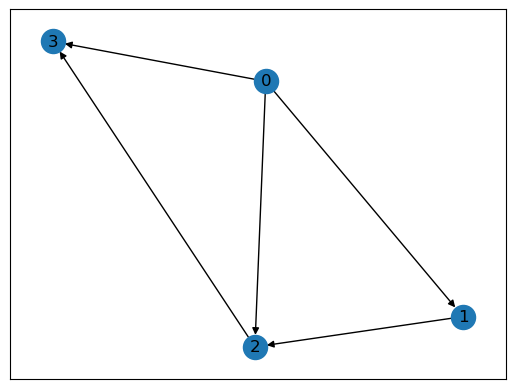

In [25]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [32]:
latent = 1 
observed = 3
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
w_id = 4

epochs = 200

n_exp = 150
betas = {}
is_real_roots = {}
betas_est_true_start = {}

n_samples = 10000
stds_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
for std in stds_list:
    betas[std] = []
    betas_est_true_start[std] = []
    is_real_roots[std] = []
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)
        
        beta = true_B[2, 1]
        betas[std].append(beta)
        
        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        
        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
        
        x0  = beta + np.random.rand()*std*beta
        init_val = x0
    
        def f_min_reg(x):
            global alpha
            global a0
            global a1
            global a2
            global a3
            global b0
            global b1
            global b2
            global b3
            global cov21
            global cov20
            global cov11
            global cov10
            global init_val

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - init_val)**2
        
        sol = optimize.minimize(f_min_reg, x0, method='BFGS')
        beta_est = sol.x[0]
        betas_est_true_start[std].append(beta_est)

In [33]:
betas_est_avg_true_start = {}
betas_est_err_true_start = {}

for key in betas.keys():
    beta_est_avg_true_start = np.median(np.abs((np.array(betas_est_true_start[key]) - np.array(betas[key])) / np.array(betas[key])))
    betas_est_avg_true_start[key] = beta_est_avg_true_start
    betas_est_err_true_start[key] = np.abs((np.array(betas_est_true_start[key]) - np.array(betas[key])) / np.array(betas[key])).std()

In [ ]:
# Add experiments where initial point is close to beta (beta+noise (var small)), plot with respect to var value

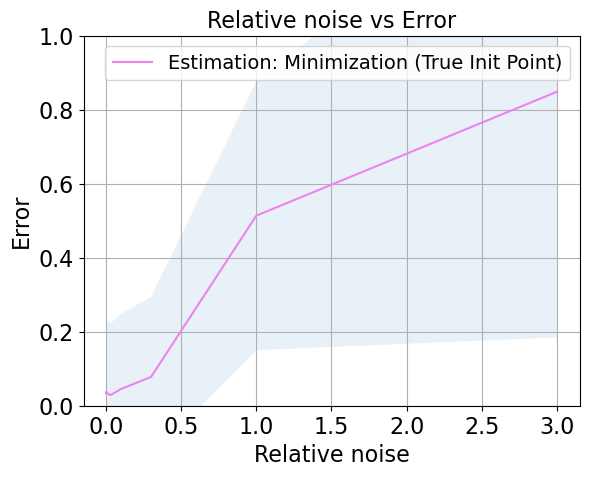

In [34]:
x = stds_list
y_true_start = np.array(list(betas_est_avg_true_start.values()))
err_true_start = np.array(list(betas_est_err_true_start.values()))

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Relative noise vs Error")
plt.xlabel("Relative noise")
plt.ylabel("Error")

plt.plot(x, y_true_start, label="Estimation: Minimization (True Init Point)", color="violet")
plt.fill_between(x, y_true_start-err_true_start, y_true_start+err_true_start, alpha=0.1)

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1)
plt.show()

In [ ]:
# noise_distribution = "beta"
n_exp = 100
alphas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1] 
betas = {}
betas_cumulant = {}
betas_est = {}

n_samples_list = [1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000, 13000, 15000, 25000, 50000, 100000]
for n_samples in n_samples_list:
    betas_cumulant[n_samples] = []
    betas[n_samples] = []
    for alpha in alphas:
        betas_est[(alpha, n_samples)] = []
    
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect

        beta = true_B[2, 1]
        betas[n_samples].append(beta)
        betas_cumulant[n_samples].append(causal_effect_estimate_cumulant)

        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
        
        for alpha in alphas:
            def f_min_reg(x):
                global alpha
                global a0
                global a1
                global a2
                global a3
                global b0
                global b1
                global b2
                global b3
                global cov21
                global cov20
                global cov11
                global cov10
                global causal_effect_estimate_cumulant

                k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

                return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - causal_effect_estimate_cumulant)**2

            x0  = causal_effect_estimate_cumulant
            sol = optimize.minimize(f_min_reg, x0, method='BFGS')
            beta_est = sol.x[0]
            betas_est[(alpha, n_samples)].append(beta_est)

In [ ]:
betas_est_avg = {}
betas_est_avg_cumulant = {}
for key in betas.keys():
    beta_est_avg_cumulant = np.abs((np.array(betas_cumulant[key]) - np.array(betas[key])) / np.array(betas[key])).mean()
    betas_est_avg_cumulant[key] = beta_est_avg_cumulant
    
for key in betas_est.keys():
    key_samples = key[1]
    beta_est_avg = np.abs((np.array(betas_est[key]) - np.array(betas[key_samples])) / np.array(betas[key_samples])).mean()
    betas_est_avg[key] = beta_est_avg

In [ ]:
x = n_samples_list
y_cumulant = list(betas_est_avg_cumulant.values())
y_alpha = {}
for alpha in alphas:
    y_alpha[alpha] = [val for key, val in betas_est_avg.items() if key[0]==alpha]

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

fig, axs = plt.subplots(len(alphas), figsize=(10, 10*len(alphas)))

# axs.rc('font', size=BIGGER_SIZE)
# axs.rc('axes', titlesize=BIGGER_SIZE)
# axs.rc('axes', labelsize=BIGGER_SIZE)
# axs.rc('xtick', labelsize=BIGGER_SIZE)
# axs.rc('ytick', labelsize=BIGGER_SIZE)
# axs.rc('legend', fontsize=MEDIUM_SIZE)
# axs.rc('figure', titlesize=BIGGER_SIZE)

for i in range(len(alphas)):
    axs[i].set_title(f"Alpha: {alphas[i]}")
    axs[i].plot(x, y_alpha[alphas[i]], label="Estimation", color="blue")
    axs[i].plot(x, y_cumulant, label="Estimation Cumulant", color="red")
    axs[i].set_xlabel("Number of samples")
    axs[i].set_ylabel("Error")
    axs[i].legend(loc="upper right")
    
# Plot the results
plt.show()

In [ ]:
# noise_distribution = "beta"
n_exp = 1000
alphas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1] 
betas = {}
betas_cumulant = {}
betas_est = {}

n_samples_list = [1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000, 13000, 15000, 25000, 50000, 100000]
for n_samples in n_samples_list:
    betas_cumulant[n_samples] = []
    betas[n_samples] = []
    for alpha in alphas:
        betas_est[(alpha, n_samples)] = []
    
    for i in range(n_exp):
        n = n_samples
        X, true_B = simulate_data(n,
                                  noise_distribution=noise_distribution,
                                  Lambda=Lambda,
                                  Gamma=Gamma,
                                  permute_order=False)
        X_sample = np.asfortranarray(X)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect

        beta = true_B[2, 1]
        betas[n_samples].append(beta)
        betas_cumulant[n_samples].append(causal_effect_estimate_cumulant)

        Z, X, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2] 

        YYZ = (Y*Y*Z).mean()
        YXZ = (Y*X*Z).mean()
        XXZ = (X*X*Z).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        a0 = YYZ * YXX
        a1 = -XXX*YYZ - 2*YXZ*YXX
        a2 = XXZ*YXX + 2*YXZ*XXX
        a3 = -XXZ*XXX

        YZZ = (Y*Z*Z).mean()
        XZZ = (X*Z*Z).mean()
        YYX = (Y*Y*X).mean()
        YXX = (Y*X*X).mean()
        XXX = (X*X*X).mean()
        b0 = YZZ*YYX
        b1 = -XZZ*YYX - 2*YXX*YZZ
        b2 = YZZ*XXX + 2*YXX*XZZ
        b3 = -XZZ*XXX

        cov21 = (Y*X).mean()
        cov20 = (Y*Z).mean()
        cov11 = (X*X).mean()
        cov10 = (X*Z).mean()
        
        for alpha in alphas:
            def f_min_reg(x):
                global alpha
                global a0
                global a1
                global a2
                global a3
                global b0
                global b1
                global b2
                global b3
                global cov21
                global cov20
                global cov11
                global cov10
                global causal_effect_estimate_cumulant

                k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

                return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - causal_effect_estimate_cumulant)**2

            x0  = causal_effect_estimate_cumulant
            sol = optimize.minimize(f_min_reg, x0, method='BFGS')
            beta_est = sol.x[0]
            betas_est[(alpha, n_samples)].append(beta_est)

In [ ]:
betas_est_avg = {}
betas_est_avg_cumulant = {}
for key in betas.keys():
    beta_est_avg_cumulant = np.abs((np.array(betas_cumulant[key]) - np.array(betas[key])) / np.array(betas[key])).mean()
    betas_est_avg_cumulant[key] = beta_est_avg_cumulant
    
for key in betas_est.keys():
    key_samples = key[1]
    beta_est_avg = np.abs((np.array(betas_est[key]) - np.array(betas[key_samples])) / np.array(betas[key_samples])).mean()
    betas_est_avg[key] = beta_est_avg

In [ ]:
x = n_samples_list
y_cumulant = list(betas_est_avg_cumulant.values())
y_alpha = {}
for alpha in alphas:
    y_alpha[alpha] = [val for key, val in betas_est_avg.items() if key[0]==alpha]

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

fig, axs = plt.subplots(len(alphas), figsize=(10, 10*len(alphas)))

# axs.rc('font', size=BIGGER_SIZE)
# axs.rc('axes', titlesize=BIGGER_SIZE)
# axs.rc('axes', labelsize=BIGGER_SIZE)
# axs.rc('xtick', labelsize=BIGGER_SIZE)
# axs.rc('ytick', labelsize=BIGGER_SIZE)
# axs.rc('legend', fontsize=MEDIUM_SIZE)
# axs.rc('figure', titlesize=BIGGER_SIZE)

for i in range(len(alphas)):
    axs[i].set_title(f"Alpha: {alphas[i]}")
    axs[i].plot(x, y_alpha[alphas[i]], label="Estimation", color="blue")
    axs[i].plot(x, y_cumulant, label="Estimation Cumulant", color="red")
    axs[i].set_xlabel("Number of samples")
    axs[i].set_ylabel("Error")
    axs[i].legend(loc="upper right")
    
# Plot the results
plt.show()